In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from pyTVDN.TVDNutils import GetBsplineEst
from scipy.signal import detrend
from easydict import EasyDict as edict
%matplotlib inline
from pyTVDN.TVDNutils import *
from pyTVDN.Rfuns import decimate_R
from pyTVDN.utils import in_notebook

In [10]:
# Reconstruct Xmat from results
def ReconXmat1(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, lamAdjFct=1, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    LamMs.imag = LamMs.imag * lamAdjFct
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    for i in range(1, n):
        mTerm = np.diag(LamMs[:, i])
        rTerm = invEigVecsr.dot(EstXmat[:, i-1])
        EstXmat[:, i] = eigVecsr.dot(mTerm).dot(rTerm) * tStep + EstXmat[:,i-1]
        #EstXmat[:, i] = eigVecsr.dot(mTerm).dot(rTerm)
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        return ReDict
    else:
        return detrend(EstXmat.real)

In [11]:
import numpy as np
from pprint import pprint
from pathlib import Path
from scipy.signal import detrend
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from easydict import EasyDict as edict
from prettytable import PrettyTable
import warnings
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def __init__(self, Ymat, dataType=None, saveDir=None, showProgress=True, lamAdjFct=1, **paras):
        """
        Input:
            Ymat: The data matrix, d x n
            dataType: real data type, fMRI or MEG
            saveDir: Dir to save the results, if not specified, not save
            paras: Other parameters. There are default valuesi but you may specify these parameters manually.
               Inlcuding:
                    kappa: The parameter of penalty in MBIC
                    Lmin: The minimal length between 2 change points
                    r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
                    MaxM: int, maximal number of change point 
                    lamb: The smooth parameter for B-spline
                    downRate: The downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors.
                    decimateRate: Mainly for MEG data. The rate to decimate from MEG data.
                    T: The time course
                    is_detrend: Whether detrend data or not
                    fct: The factor to adjust h when estimating A matrix
                    fName:  The file name when saving the results
                    plotfct: The factor to adjust the time course when plotting
                    freq: The parameter used drawing the eigen values plots
        """
        self.Ymat = Ymat
        self.paras = edict()
        if dataType is not None:
            self.dataType = dataType.lower()
        else:
            self.dataType = dataType


        if self.dataType == "meg":
            self.paras.kappa = 2.65
            self.paras.Lmin = 60
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-4
            self.paras.downRate = 20
            self.paras.decimateRate = 10
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "MEG"
            self.paras.plotfct = 30
            self.paras.freq = 60
        elif self.dataType == "fmri":
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 10
            self.paras.lamb = 1e-4
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "fMRI"
            self.paras.plotfct = 180
            self.paras.freq = 0.5
        else:
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-6
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 1
            self.paras.fName = "simu"
            self.paras.plotfct = 1
            self.paras.freq = 180
        keys = list(self.paras.keys())
        for key in paras.keys():
            self.paras[key] = paras[key]
        if showProgress:
            print("The parameters for detection are:")
            pprint(self.paras)
        
        if saveDir is not None:
            self.saveDir = Path(saveDir)
            if not self.saveDir.exists():
                self.saveDir.mkdir()
        else:
            self.saveDir = saveDir
            
        self.showProgress = showProgress
        self.lamAdjFct = lamAdjFct
        self.nYmat = None
        self.Xmat = None
        self.dXmat = None
        self.time = None
        self.midRes = None
        self.nXmat = None
        self.ndXmat = None
        self.Amat = None
        self.finalRes = None
        self.RecYmatAll = None
        self.RecResCur = None
        self.numchgs = None
        self.ecpts = None
        self.canpts = None
    

    def __GetRecResCur(self):
        numchg = len(self.ecpts)
        if self.RecYmatAll is not None:
            self.RecResCur = self.RecYmatAll[numchg]
        elif self.saveDir is not None:
            RecYmatAllPath = self.saveDir/f"{self.paras.fName}_Rank{self.paras.r}_RecAll.pkl"
            if RecYmatAllPath.exists():
                with open(RecYmatAllPath, "rb") as f:
                    self.RecYmatAll = pickle.load(f)
                self.RecResCur = self.RecYmatAll[numchg]
            else:
                MaxM = self.paras.MaxM
                r = self.paras.r
                finalRes = self.finalRes
                midRes = self.midRes
                _, n = midRes.nXmat.shape
                time = np.linspace(0, self.paras.T, n)
                tStep = np.diff(time)[0]
                ndXmat = midRes.ndXmat
                nXmat = midRes.nXmat
                kpidxs = midRes.kpidxs
                eigVecs = midRes.eigVecs
                self.RecResCur = ReconXmat1(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, 
                                            r=r, lamAdjFct=self.lamAdjFct, is_full=True) 
        else:
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            self.RecResCur = ReconXmat1(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, 
                                        lamAdjFct=self.lamAdjFct,
                                        is_full=True) 
    
    def __GetRecYmats(self):
        if self.RecYmatAll is None:
            RecYmatAll = []
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            if self.showProgress:
                pbar = tqdm(range(MaxM+1))
                for numchg in pbar:
                    pbar.set_description(f"Kappa Tuning")
        #            print(f"Current number of change point is {numchg}.")
                    if numchg == 0:
                        RecResCur = ReconXmat1([], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, 
                                               lamAdjFct=self.lamAdjFct,
                                               is_full=True) 
                    else:
                        RecResCur = ReconXmat1(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, 
                                               r=r, lamAdjFct=self.lamAdjFct, is_full=True) 
                    RecYmatAll.append(RecResCur)
            else:
                for numchg in range(MaxM+1):
                    if numchg == 0:
                        RecResCur = ReconXmat1([], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, lamAdjFct=self.lamAdjFct, is_full=True) 
                    else:
                        RecResCur = ReconXmat1(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, 
                                               tStep, r=r, lamAdjFct=self.lamAdjFct, is_full=True) 
                    RecYmatAll.append(RecResCur)
            self.RecYmatAll = RecYmatAll
    

In [12]:
resDir = Path("../results")
dataDir = Path("../data")

In [13]:
filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

## Obtain the dataset

In [14]:
fMRI = fMRIs[0, 9]["fMRI"][:90, :]

## Change the scale of imaginery part

In [15]:
fMRIdet = TVDNDetect(Ymat=fMRI, saveDir=None, dataType="fMRI", fName="fMRIsample", showProgress=True, lamAdjFct=0.5, 
                     r=6, kappa=1.65, fct=0.5, lamb=8e-5, plotfct=180, downRate=4, MaxM=40, Lmin=2, freq=0.5, is_detrend=True)

The parameters for detection are:
{'Lmin': 2,
 'MaxM': 40,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRIsample',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': True,
 'kappa': 1.65,
 'lamAdjFct': 0.5,
 'lamb': 8e-05,
 'plotfct': 180,
 'r': 6}


In [16]:
fMRIdet()

In [17]:
kappas = np.arange(1.0, 2.0, step=0.01)
fMRIdet.TuningKappa(kappas)

In [18]:
fMRIdet.UpdateEcpts(5)

In [19]:
print(fMRIdet)

+-------------+----------------------------+-------------------+------+
| Num of CPTs |       Estiamted CPTs       |        MSE        | Rank |
+-------------+----------------------------+-------------------+------+
|      5      | [ 11.  29.  56.  85. 157.] | 1.034320236885844 |  6   |
+-------------+----------------------------+-------------------+------+


The plot indices are [60, 27, 40].


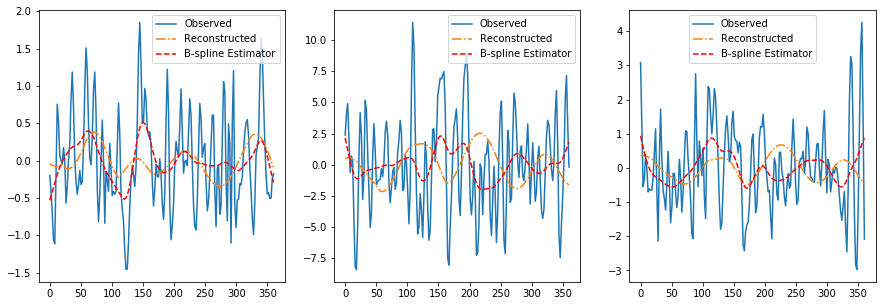

In [20]:
#fMRIdet.PlotRecCurve(is_bsp=1, saveFigPath=None)
fMRIdet.PlotRecCurve(idxs=[60, 27, 40], is_bsp=1, saveFigPath=None)

# Change the model

Current model is $X_t = A(t) X_{t-1}$.

## 1. Detection with No Bspline

1. Detrend the observation
2. No B-spline
3. Do the detection
4. Plot the (detrended) observed `Ymat` and reconstructed `Xmat`

In [44]:
fMRIdetNoSpl = TVDNDetect(Ymat=fMRI[:, :-1], saveDir=None, dataType="fMRI", fName="fMRIsample", showProgress=True,
                     r=2, kappa=1.65, fct=0.5, lamb=8e-5, plotfct=180, downRate=4, MaxM=40, Lmin=2, freq=0.5, is_detrend=True)

The parameters for detection are:
{'Lmin': 2,
 'MaxM': 40,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRIsample',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': True,
 'kappa': 1.65,
 'lamb': 8e-05,
 'plotfct': 180,
 'r': 2}


In [45]:
fMRIdetNoSpl._Preprocess()

In [46]:
Xmat = fMRI[:, :-1]
dXmat = fMRI[:, 1:]

In [47]:
fMRIdetNoSpl.dXmat, fMRIdetNoSpl.Xmat = dXmat, Xmat

In [16]:
fMRIdetNoSpl()

In [17]:
kappas = np.arange(1.0, 2.0, step=0.01)
fMRIdetNoSpl.TuningKappa(kappas)

In [50]:
print("The optimal kappas are:", fMRIdetNoSpl.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", fMRIdetNoSpl.optKappaOptNumChg)
print("The optimal number of change point is:", fMRIdetNoSpl.optNumChg)

The optimal kappas are: 1.0
The optimal number of change point under the range of kappa we speicified is: 0
The optimal number of change point is: 34


In [51]:
fMRIdetNoSpl.UpdateEcpts(20)
print(fMRIdetNoSpl)

+-------------+------------------------------------------------------------------------+--------------------+------+
| Num of CPTs |                             Estiamted CPTs                             |        MSE         | Rank |
+-------------+------------------------------------------------------------------------+--------------------+------+
|      20     | [ 14.  19.  21.  29.  31.  33.  41.  59.  61.  71.  78. 114. 116. 118. | 1.0260522846203406 |  2   |
|             |                     122. 124. 161. 163. 166. 168.]                     |                    |      |
+-------------+------------------------------------------------------------------------+--------------------+------+


### No detrended reconstructed curve

The plot indices are [0, 1].


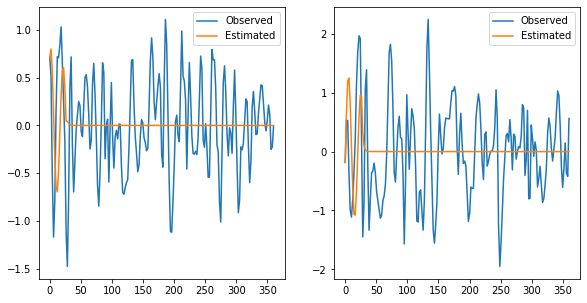

In [37]:
fMRIdetNoSpl.PlotRecCurve(idxs=[0, 1])

### Detrend the estimated `Xmat` and plot the results

In [17]:
fMRIdetNoSpl.RecResCur.EstXmatReal = detrend(fMRIdetNoSpl.RecResCur.EstXmatReal)

The plot indices are [50, 2, 60, 76, 9].


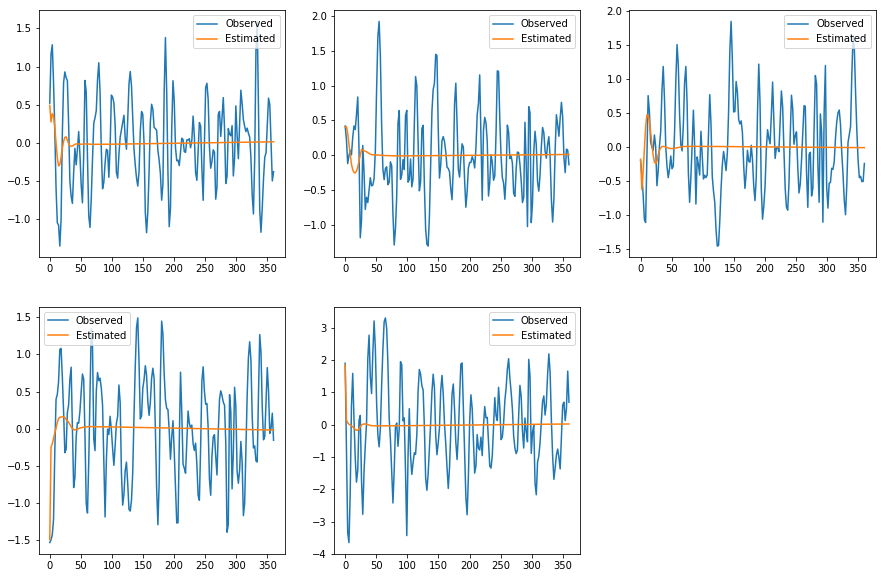

In [18]:
fMRIdetNoSpl.PlotRecCurve(idxs=[50, 2, 60, 76, 9])

## 2. Detection with  B-spline seperate on `Xmat` and `dXmat`

2. Detrend the observation
1. Do b-spline seperately on `Xmat`(`8e-5`) and `dXmat`(`8e-5`)
3. Do the detection
4. Plot the (detrended) observed `Ymat` and reconstructed `Xmat`

In [50]:
fMRIdet = TVDNDetect(Ymat=fMRI[:, :-1], saveDir=None, dataType="fMRI", fName="fMRIsample", showProgress=True,
                     r=20, kappa=1.65, fct=0.5, lamb=8e-5, plotfct=180, downRate=4, MaxM=40, Lmin=2, freq=0.5, is_detrend=True)

The parameters for detection are:
{'Lmin': 2,
 'MaxM': 40,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRIsample',
 'fct': 0.5,
 'freq': 0.5,
 'is_detrend': True,
 'kappa': 1.65,
 'lamb': 8e-05,
 'plotfct': 180,
 'r': 20}


In [51]:
fMRIdet._Preprocess()

In [52]:
d, n = fMRIdet.nYmat.shape
T = fMRIdet.paras.T
time = np.linspace(0, T, n)

In [53]:
Xmat = fMRI[:, :-1]
dXmat = fMRI[:, 1:]

In [54]:
_, Xmat = GetBsplineEst(Xmat, time, lamb=8e-5)
_, dXmat = GetBsplineEst(dXmat, time, lamb=8e-5)

In [55]:
fMRIdet.dXmat, fMRIdet.Xmat = dXmat, Xmat

In [56]:
fMRIdet()

In [57]:
kappas = np.arange(1.0, 2.0, step=0.01)
fMRIdet.TuningKappa(kappas)

In [58]:
print("The optimal kappas are:", fMRIdet.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", fMRIdet.optKappaOptNumChg)
print("The optimal number of change point is:", fMRIdet.optNumChg)

The optimal kappas are: 1.0
The optimal number of change point under the range of kappa we speicified is: 3
The optimal number of change point is: 22


In [60]:
fMRIdet.UpdateEcpts(22)
print(fMRIdet)

+-------------+------------------------------------------------------------------------+--------------------+------+
| Num of CPTs |                             Estiamted CPTs                             |        MSE         | Rank |
+-------------+------------------------------------------------------------------------+--------------------+------+
|      22     | [  2.  46.  48.  50.  52.  54.  56.  58. 104. 106. 155. 157. 159. 161. | 14.430345200524478 |  20  |
|             |                163. 165. 167. 169. 171. 173. 175. 177.]                |                    |      |
+-------------+------------------------------------------------------------------------+--------------------+------+


### No detrended reconstructed curve

The plot indices are [11 73 55 20 83].


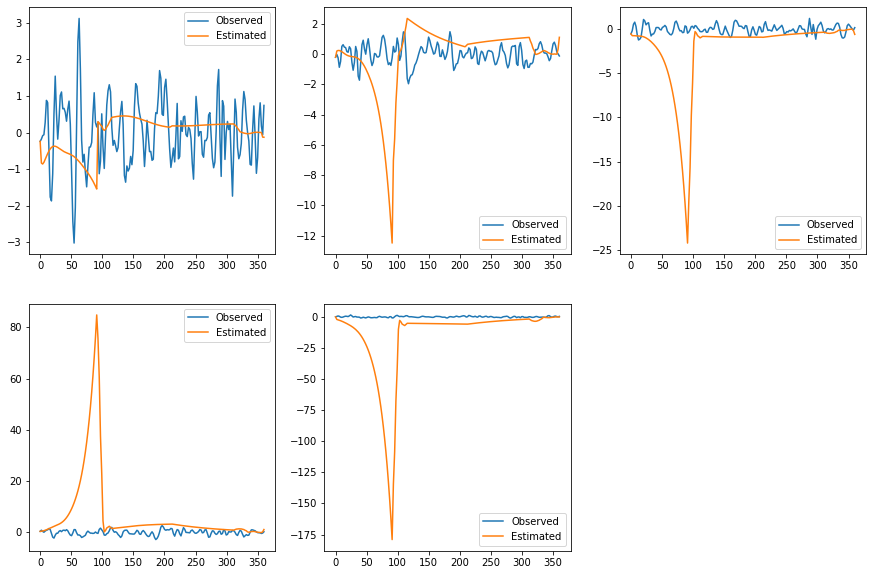

In [61]:
fMRIdet.PlotRecCurve()

### Detrend the estimated `Xmat` and plot the results

In [62]:
fMRIdet.RecResCur.EstXmatReal = detrend(fMRIdet.RecResCur.EstXmatReal)

The plot indices are [55, 78, 80, 57, 83].


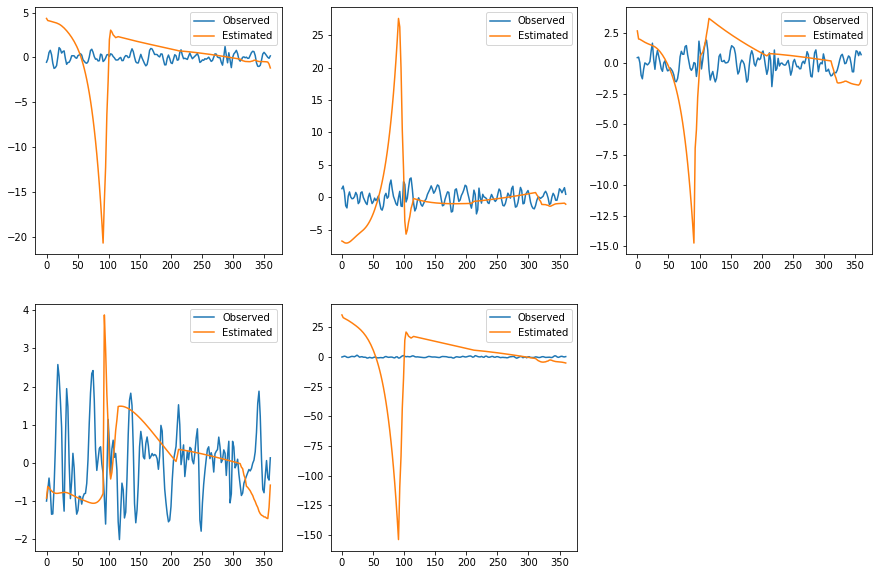

In [63]:
fMRIdet.PlotRecCurve(idxs=[55, 78, 80, 57, 83])